# Models and Evaluation

In [1035]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

TRAIN_DATA_FILE = 'data.csv'

train_data = pd.read_csv('../assets/final/' + TRAIN_DATA_FILE)
test_data = pd.read_csv('../assets/final/kaggleData.csv')

print(train_data.shape)
print(test_data.shape)

(328, 12)
(354, 12)


In [1036]:
def get_features(df):
    return df.drop('paid', axis=1)
def get_target(df):
    return df.drop(df.columns.difference(['paid']), axis=1)

results = {}

### Split data

In [1037]:
def structure_data():
    ids_train = train_data['loan_id']
    ids_test = test_data['loan_id']

    train_data.drop(['loan_id'], axis=1, inplace=True)
    test_data.drop(['loan_id'], axis=1, inplace=True)

    train_features = get_features(train_data)
    train_target = get_target(train_data)
    test_features = get_features(test_data)
    test_target = get_target(test_data)

    return train_features, test_features, train_target, test_target, ids_train, ids_test


In [1038]:
_X_train, _X_test, _y_train, _y_test, ids_train, ids_test = structure_data()

print('\nTrain data shape: ', _X_train.shape)
print('\nTest data shape: ', _X_test.shape)
print('\nTrain shape:',_y_train.shape)
print('\nTest shape:',_y_test.shape)



Train data shape:  (328, 10)

Test data shape:  (354, 10)

Train shape: (328, 1)

Test shape: (354, 1)


### Resampling

In [1039]:
def oversample(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=1, sampling_strategy=1.0)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [1040]:
_smote_X_train, _smote_y_train = oversample(_X_train, _y_train)

print('\nTrain data shape: ', _smote_X_train.shape)
print('\nTrain shape:',_smote_y_train.shape)



Train data shape:  (564, 10)

Train shape: (564, 1)


### Algorithms

In [1041]:
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold, StratifiedKFold

k = 5
kr = 3
cv = RepeatedStratifiedKFold(n_splits=k, n_repeats=kr, random_state=0)

scoring = {"accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall",
           "f1": "f1",
           "roc_auc": "roc_auc"}

In [1042]:
import datetime    

# Trains a specific Model
def add_model(name, model, use_smote=False):
    x_fit_data = _smote_X_train.copy() if use_smote else _X_train.copy()
    y_fit_data = _smote_y_train if use_smote else _y_train

    X_test = _X_test.copy()

    start = datetime.datetime.now()
    
    model.fit(x_fit_data, np.ravel(y_fit_data.values))

    # Folding data and fitting. This overwrites previous results and by some magic gives better results :)
    """ skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(x_fit_data, y_fit_data):
        #print("TRAIN:", x_fit_data.iloc[train_index], "TEST:", y_fit_data.iloc[train_index].values)
        model.fit(x_fit_data.iloc[train_index], np.ravel(y_fit_data.iloc[train_index].values)) """
        
    end = datetime.datetime.now()

    results[name] = {'model': model,
                    'X_test': X_test, 
                    'fit_time': (end - start).microseconds / 1000 # time difference in milliseconds
                    }

In [1043]:
USE_SMOTE = False

In [1044]:
from sklearn.tree import DecisionTreeClassifier
add_model('dtc',
    DecisionTreeClassifier(),
    use_smote=USE_SMOTE
)

In [1045]:
from sklearn.neighbors import KNeighborsClassifier
add_model('knn',
    KNeighborsClassifier(),
    use_smote=USE_SMOTE
)

In [1046]:
from sklearn.neural_network import MLPClassifier
add_model('mlp',
    MLPClassifier(),
    use_smote=USE_SMOTE
)

In [1047]:
from sklearn.naive_bayes import GaussianNB
add_model('gnb',
    GaussianNB(),
    use_smote=USE_SMOTE
)

In [1048]:
from sklearn.svm import SVC
add_model('svc',
    SVC(probability=True),
    use_smote=USE_SMOTE
)

In [1049]:
from sklearn.ensemble import RandomForestClassifier

add_model('rf',
    RandomForestClassifier(criterion='entropy', max_depth=6, max_features='sqrt', n_estimators=150),#criterion='entropy', max_depth=3, max_features='sqrt', n_estimators=150),
    use_smote=USE_SMOTE
)

In [1050]:
from sklearn.linear_model import LogisticRegression

add_model('lr',
    LogisticRegression(),
    use_smote=USE_SMOTE
)

## Prediction

# TODO:
- Stratified Cross-Validation. Turns out this would only make sense to test the model with the training data.
- Check if SMOTE should be applied
- Test different models
- Clustering
- Outliers
- Check Inputation
- Improve predictions

In [1051]:
def predict(name):
    result = results[name]
    pred = result['model'].predict(result['X_test'])
    result['test_pred'] = pred

for name in results.keys():
    # Predict paid column on test data
    predict(name)

In [1052]:
def predict_proba(name):
    result = results[name]
    proba = result['model'].predict_proba(result['X_test'])
    result['test_pred_prob'] = proba

for name in results.keys():
    # Predict paid column on test data (Probability)
    predict_proba(name)

In [1053]:
# Check result object
'''
test_pred -> Prediction of paid column on test data
trainpred -> Prediction of paid column on train data

test_pred_prob -> Prediction of Probability of paid column on test data
trainpred_prob -> Prediction of Probability of paid column on train data
'''
results

{'dtc': {'model': DecisionTreeClassifier(),
  'X_test':      is_co-owned  age  amount  payments  balance_min  balance_mean  \
  0              0    1   93960      1566        800.0  54520.202247   
  1              0    2  260640      7240       -718.6  31518.182051   
  2              0    3  232560      4845        200.0  40175.612500   
  3              1    2  221880      3698       1000.0  44440.912676   
  4              0    3   38520      3210        900.0  20231.313158   
  ..           ...  ...     ...       ...          ...           ...   
  349            0    2  352704      7348        800.0  30797.487500   
  350            0    2   52512      4376       1000.0  59684.298851   
  351            0    1  139488      5812       1100.0  46755.305769   
  352            0    2   55632      2318        500.0  29645.320175   
  353            0    2  240900      4015        700.0  26268.190000   
  
       a_avg_salary  mean_3m_influx  frequency_monthly issuance  \
  0         

### Check Prediction Results

In [1054]:
used_ml_model = 'rf'

In [1055]:
print("ML Model analyzed: ", used_ml_model)
print(results[used_ml_model]['test_pred_prob'])

ML Model analyzed:  rf
[[0.04113145 0.95886855]
 [0.86815496 0.13184504]
 [0.20056832 0.79943168]
 [0.01937519 0.98062481]
 [0.35406818 0.64593182]
 [0.06057385 0.93942615]
 [0.05920969 0.94079031]
 [0.15399905 0.84600095]
 [0.09081922 0.90918078]
 [0.24678599 0.75321401]
 [0.06063408 0.93936592]
 [0.09475757 0.90524243]
 [0.126112   0.873888  ]
 [0.2913466  0.7086534 ]
 [0.06014803 0.93985197]
 [0.07577952 0.92422048]
 [0.1041654  0.8958346 ]
 [0.04458934 0.95541066]
 [0.02857323 0.97142677]
 [0.04981439 0.95018561]
 [0.11681019 0.88318981]
 [0.08523396 0.91476604]
 [0.87064933 0.12935067]
 [0.07783184 0.92216816]
 [0.19967948 0.80032052]
 [0.09236913 0.90763087]
 [0.2385695  0.7614305 ]
 [0.19537846 0.80462154]
 [0.28356193 0.71643807]
 [0.28376348 0.71623652]
 [0.10023952 0.89976048]
 [0.06895855 0.93104145]
 [0.05235565 0.94764435]
 [0.06501427 0.93498573]
 [0.02747201 0.97252799]
 [0.04695394 0.95304606]
 [0.1676109  0.8323891 ]
 [0.13504125 0.86495875]
 [0.17478647 0.82521353]
 [

### Save the predictions results

In [1056]:
import os

RES_PATH = '../assets/results'
if not os.path.exists(RES_PATH):
  os.mkdir(RES_PATH)

res = {'Id': ids_test.values, 'Predicted': results[used_ml_model]['test_pred_prob'][:,0]}

df = pd.DataFrame(data=res)
df.to_csv(RES_PATH + '/submission.csv', index=False)

df

,Id,Predicted
0,5895,0.041131
1,7122,0.868155
2,6173,0.200568
3,6142,0.019375
4,5358,0.354068
...,...,...
349,4989,0.257310
350,5221,0.146031
351,6402,0.118422
352,5346,0.146527


In [1057]:
# function that opens RES_PATH + '/submission.csv' and round the Predict table in 1 decimal place
# TODO: WHAT IS THIS FOR??
def submission():
  import pandas as pd
  RES_PATH = '../assets/results'
  df = pd.read_csv(RES_PATH + '/submission.csv')
  df.to_csv(RES_PATH + '/submission.csv', index=False)

# submission()

## Evaluate Prediction with ROC Curve

Submission score: 0.916358024691358% (~0.92%)


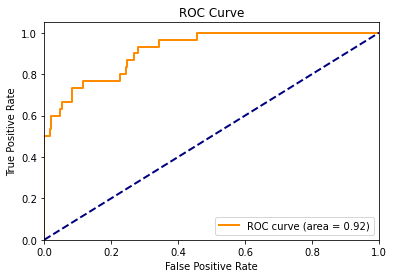

In [1058]:
import pandas as pd

SHOW_GRAPH = True

SUBMISSION_PATH = "../assets/results/submission.csv"
RESULTS_PATH = "../assets/complete_clean/loan_dev.csv"

submission_pd = pd.read_csv(SUBMISSION_PATH)
results_pd = pd.read_csv(RESULTS_PATH)
mix_pd = pd.merge(submission_pd, results_pd, left_on='Id', right_on='loan_id', how='inner')

submission_scores = mix_pd["Predicted"].values.tolist()
results = mix_pd["paid"].values.tolist()

fpr, tpr, thresholds = roc_curve(results, submission_scores, pos_label=0)
auc = auc(fpr, tpr)

print(f"Submission score: {auc}% (~{round(auc, 2)}%)")

if SHOW_GRAPH:
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


---------------------